In [1]:
import pandas as pd
import numpy as np
import itertools
import time
import statsmodels.api as sm
import sys
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier

df = pd.read_csv('historical_data1_time_Q12016_clean.csv')

/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
y = df['curr_loan_delinquency_status']
df = df.dropna().drop(['loan_sequence_no', 'monthly_reporting_period', 
                      'curr_loan_delinquency_status'], axis=1).astype('float64')
X = df

In [3]:
def processSubset(feature_set):
# Fit model on feature_set and calculate RSS
    model = MLPClassifier()
    model = model.fit(X[list(feature_set)], y)
    Score = model.score(X[list(feature_set)], y)
    return {"model":model, "score":Score, "feature":X[list(feature_set)]}

In [4]:
def forward(predictors):
    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    tic = time.time()
    results = []
    for p in remaining_predictors:
        model = processSubset(predictors+[p])
        results.append(model)
        
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    # Choose the model with the highest RSS
    best_model = models.loc[models['score'].argmax()]
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    # Return the best model, along with some other useful information about the model
    print best_model
    return best_model

models2 = pd.DataFrame(columns=["score", "model", "feature"])
tic = time.time()
predictors = []

for i in range(1,len(X.columns)+1):
    models2.loc[i] = forward(predictors)
    predictors = list(models2.loc[i]["feature"])
    
toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")
print predictors

('Processed ', 5, 'models on', 1, 'predictors in', 1.5954430103302002, 'seconds.')
feature           curr_interest_rate
0                   ...
model      MLPClassifier(activation='relu', alpha=0.0001,...
score                                               0.601016
Name: 3, dtype: object
('Processed ', 4, 'models on', 2, 'predictors in', 1.7680981159210205, 'seconds.')
feature           curr_interest_rate  loan_age
0         ...
model      MLPClassifier(activation='relu', alpha=0.0001,...
score                                               0.631094
Name: 1, dtype: object
('Processed ', 3, 'models on', 3, 'predictors in', 1.1599838733673096, 'seconds.')
feature           curr_interest_rate  loan_age  curr_defe...
model      MLPClassifier(activation='relu', alpha=0.0001,...
score                                               0.638281
Name: 2, dtype: object
('Processed ', 2, 'models on', 4, 'predictors in', 1.193972110748291, 'seconds.')
feature           curr_interest_rate  loan_age  cur

In [5]:
def getBestModel(models):
    length = len(models.index)
    bestModel = models.loc[1]
    score = models.loc[1]["score"]
    for i in range (1, length + 1):
        if models.loc[i]["score"] > score:
            bestModel = models.loc[i]
            score = models.loc[i]["score"]
    return bestModel

bestmodel_forward = getBestModel(models2)

# ROC curve and Confusion matrices for training datasets

## we are using TPR(True Positive Rate) and FPR(False Positive Rate)
## TPR = TP / (TP + FN)    and     FPR = FP / (FP + TN)
## TP = True Positive    FN = Flase Negative
## FP = Flase Positve   TN = True Negative

In [6]:
 y_predicted = bestmodel_forward["model"].predict(X[list(bestmodel_forward["feature"])])

In [8]:
from sklearn import metrics
conf_mat_logred_training = metrics.confusion_matrix(y, y_predicted)
print(conf_mat_logred_training)

[[3345 3055]
 [1575 4825]]


In [10]:
bestmodel_forward["model"].score(X[list(bestmodel_forward["feature"])], y)

0.63828125000000002

('Logred', '             precision    recall  f1-score   support\n\n          0       0.68      0.52      0.59      6400\n          1       0.61      0.75      0.68      6400\n\navg / total       0.65      0.64      0.63     12800\n')


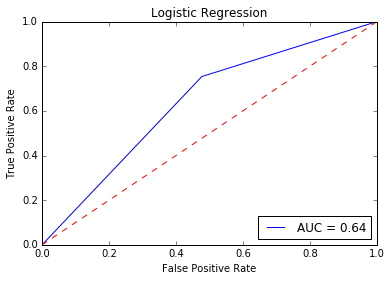

In [13]:
from sklearn import metrics
from sklearn.metrics import classification_report
from multiprocessing import Process, Lock, Manager
import matplotlib.pyplot as plt

manager = Manager()
return_dict_logred=manager.dict()
# Compute ROC curve and AUC (Area under the Curve)
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y, y_predicted)
    
roc_auc_logred = metrics.auc(false_positive_rate, true_positive_rate)
return_dict_logred['roc_auc_logred']=roc_auc_logred
return_dict_logred['conf_mat_logred']=conf_mat_logred_training
    
report = classification_report(y, y_predicted)
print("Logred",report)
    
## Plot ROC Curve
plt.title("Logistic Regression")
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc_logred)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()